In [1]:
import re
import pandas as pd
import numpy as np
from firebase_admin import credentials, firestore, initialize_app
import matplotlib.pyplot as plt
%matplotlib inline

initialize_app(credentials.Certificate('cred.json'))
db = firestore.client()

In [2]:
keys_expected = 11

def filter_func(x):
    keys = x.keys()
    vals = x.values();
    
    if (len(keys) != keys_expected):
        return False
    
    if ('undefined' in vals or None in vals):
        return False
    
    return True
    

logs = list(filter(filter_func, map(lambda x: x.to_dict(), db.collection('logs').stream())))
display(len(logs))

6404

In [3]:
key = 'combined_key'
df = pd.DataFrame(logs)
df.set_index('id', inplace = True)
df[key] = df.apply(lambda row: row.serverType + ' + ' + row.databaseType, axis = 1)
df.head()

,timeWrite,databaseType,totalTime,timestamp,serverType,clientTotalTime,timeRead,requestSize,frequency,timeDelete,combined_key
id,,,,,,,,,,,
-154RXO_,67,nosql,217,1584461244887,java,8743,39,1,5,29,java + nosql
-1dDKDwMA,62,sql,247,1584488153521,java,9903,2,1,5,8,java + sql
-2m4PfQZl,54,nosql,169,1584489502071,java,10092,18,1,5,66,java + nosql
-45mb8wl,41,nosql,136,1584503294576,nodejs,279,24,5,5,41,nodejs + nosql
-5DJdPfC,75,nosql,254,1584426403710,java,10325,26,1,5,80,java + nosql


In [4]:
display(df.shape, df.dtypes, df['requestSize'].unique(), df[key].unique())

(6404, 11)

timeWrite           int64
databaseType       object
totalTime           int64
timestamp           int64
serverType         object
clientTotalTime     int64
timeRead            int64
requestSize        object
frequency          object
timeDelete          int64
combined_key       object
dtype: object

array(['1', '5'], dtype=object)

array(['java + nosql', 'java + sql', 'nodejs + nosql', 'nodejs + sql'],
      dtype=object)

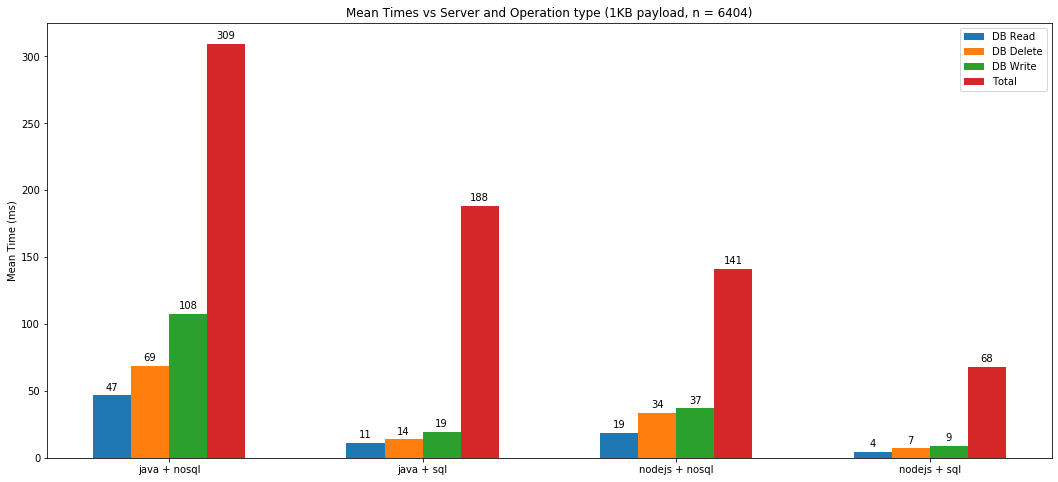

In [6]:
labels = df[key].unique()
req_size = '1'

write = 'timeWrite'
read = 'timeRead'
delete = 'timeDelete'
total = 'totalTime'


write_means = []
read_means = []
delete_means = []
total_means = []

for label in labels:
    new_df = df.loc[(df[key] == label) & (df['requestSize'] == req_size)].copy()
    
    write_mean = new_df[[write]].to_numpy().mean()
    read_mean = new_df[[read]].to_numpy().mean()
    delete_mean = new_df[[delete]].to_numpy().mean()
    total_mean = new_df[[total]].to_numpy().mean()
    
    write_means.append(write_mean)
    read_means.append(read_mean)
    delete_means.append(delete_mean)
    total_means.append(total_mean)
    

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ind = np.arange(len(labels))  
width = 0.15 

fig, ax = plt.subplots()
rects2 = ax.bar(ind - 1.5 * width, read_means, width, label = 'DB Read')
rects3 = ax.bar(ind - 0.5 * width, delete_means, width, label = 'DB Delete')
rects1 = ax.bar(ind + 0.5 * width, write_means, width, label = 'DB Write')
rects4 = ax.bar(ind + 1.5 * width, total_means, width, label = 'Total')

ax.set_ylabel('Mean Time (ms)')
ax.set_ylim(0)
ax.set_title('Mean Times vs Server and Operation type (1KB payload, n = 6404)')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend()
ax.autoscale_view()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.set_size_inches(18, 8)
plt.show()